<a href="https://colab.research.google.com/github/Tam107/BDM/blob/test/EE_%2B_RF_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor  # Added for Random Forest
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print("Libraries imported successfully")

Libraries imported successfully


Cell 2: Load and Select Columns

In [4]:
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)
print("5 dòng đầu tiên của dataset:")
print(data.head())
print("\nThông tin dataset:")
print(data.info())

5 dòng đầu tiên của dataset:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-1

Cell 3: Data Preprocessing

In [5]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\n5 dòng đầu tiên sau khi xử lý:")
print(data.head())
print("\nThông tin dataset sau xử lý:")
print(data.info())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

5 dòng đầu tiên sau khi xử lý:
      price vehicleType   powerPS    model  kilometer  monthOfRegistration  \
0  0.010168     unknown  0.203390     golf   1.000000             0.454545   
1  0.499863       coupe  0.491525  unknown   0.827586             0.363636   
2  0.266282         suv  0.400000    grand   0.827586             0.636364   
3  0.038197  kleinwagen  0.101695     golf   1.000000             0.454545   
4  0.095905  kleinwagen  0.081356    fabia   0.586207             0.545455   

  fuelType       brand  adYear   car_age  powerPS_per_km  age_km_interaction  \
0   benzin  volkswagen     1.0  0.641026        0.000199            0.406100   
1   die

Cell 4: Train-Test Split

In [6]:
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Encode Categorical Variables for Embedding (MLP)

In [7]:
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    unique_cat = np.unique(X_train_new[col])
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_cat)}
    input_list_train_new.append(X_train_new[col].map(cat_encoders[col]).values.astype(np.int32))
    input_list_val.append(X_val[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(cat_encoders[col]).fillna(0).values.astype(np.int32))
    print(f'\nCó {len(unique_cat)} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

numeric_cols = [col for col in X_train_new.columns if col not in ['brand', 'model', 'vehicleType', 'fuelType']]
input_list_train_new.append(X_train_new[numeric_cols].values.astype(np.float32))
input_list_val.append(X_val[numeric_cols].values.astype(np.float32))
input_list_test.append(X_test[numeric_cols].values.astype(np.float32))

y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.


Cell 6: Define Embedding Dimensions and Build MLP Model


Tóm tắt mô hình MLP:


Model: "Enhanced_EE_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 8)           │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 15)          │          3,750 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 5)           │             45 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 4)           │             32 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8)              │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 15)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 5)              │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 4)              │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 11)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 43)             │              0 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0],       │
│                           │                        │                │ reshape_2[0][0],       │
│                           │                        │                │ reshape_3[0][0],       │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         11,264 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 60,468 (236.20 KB)

 Trainable params: 59,572 (232.70 KB)

 Non-trainable params: 896 (3.50 KB)

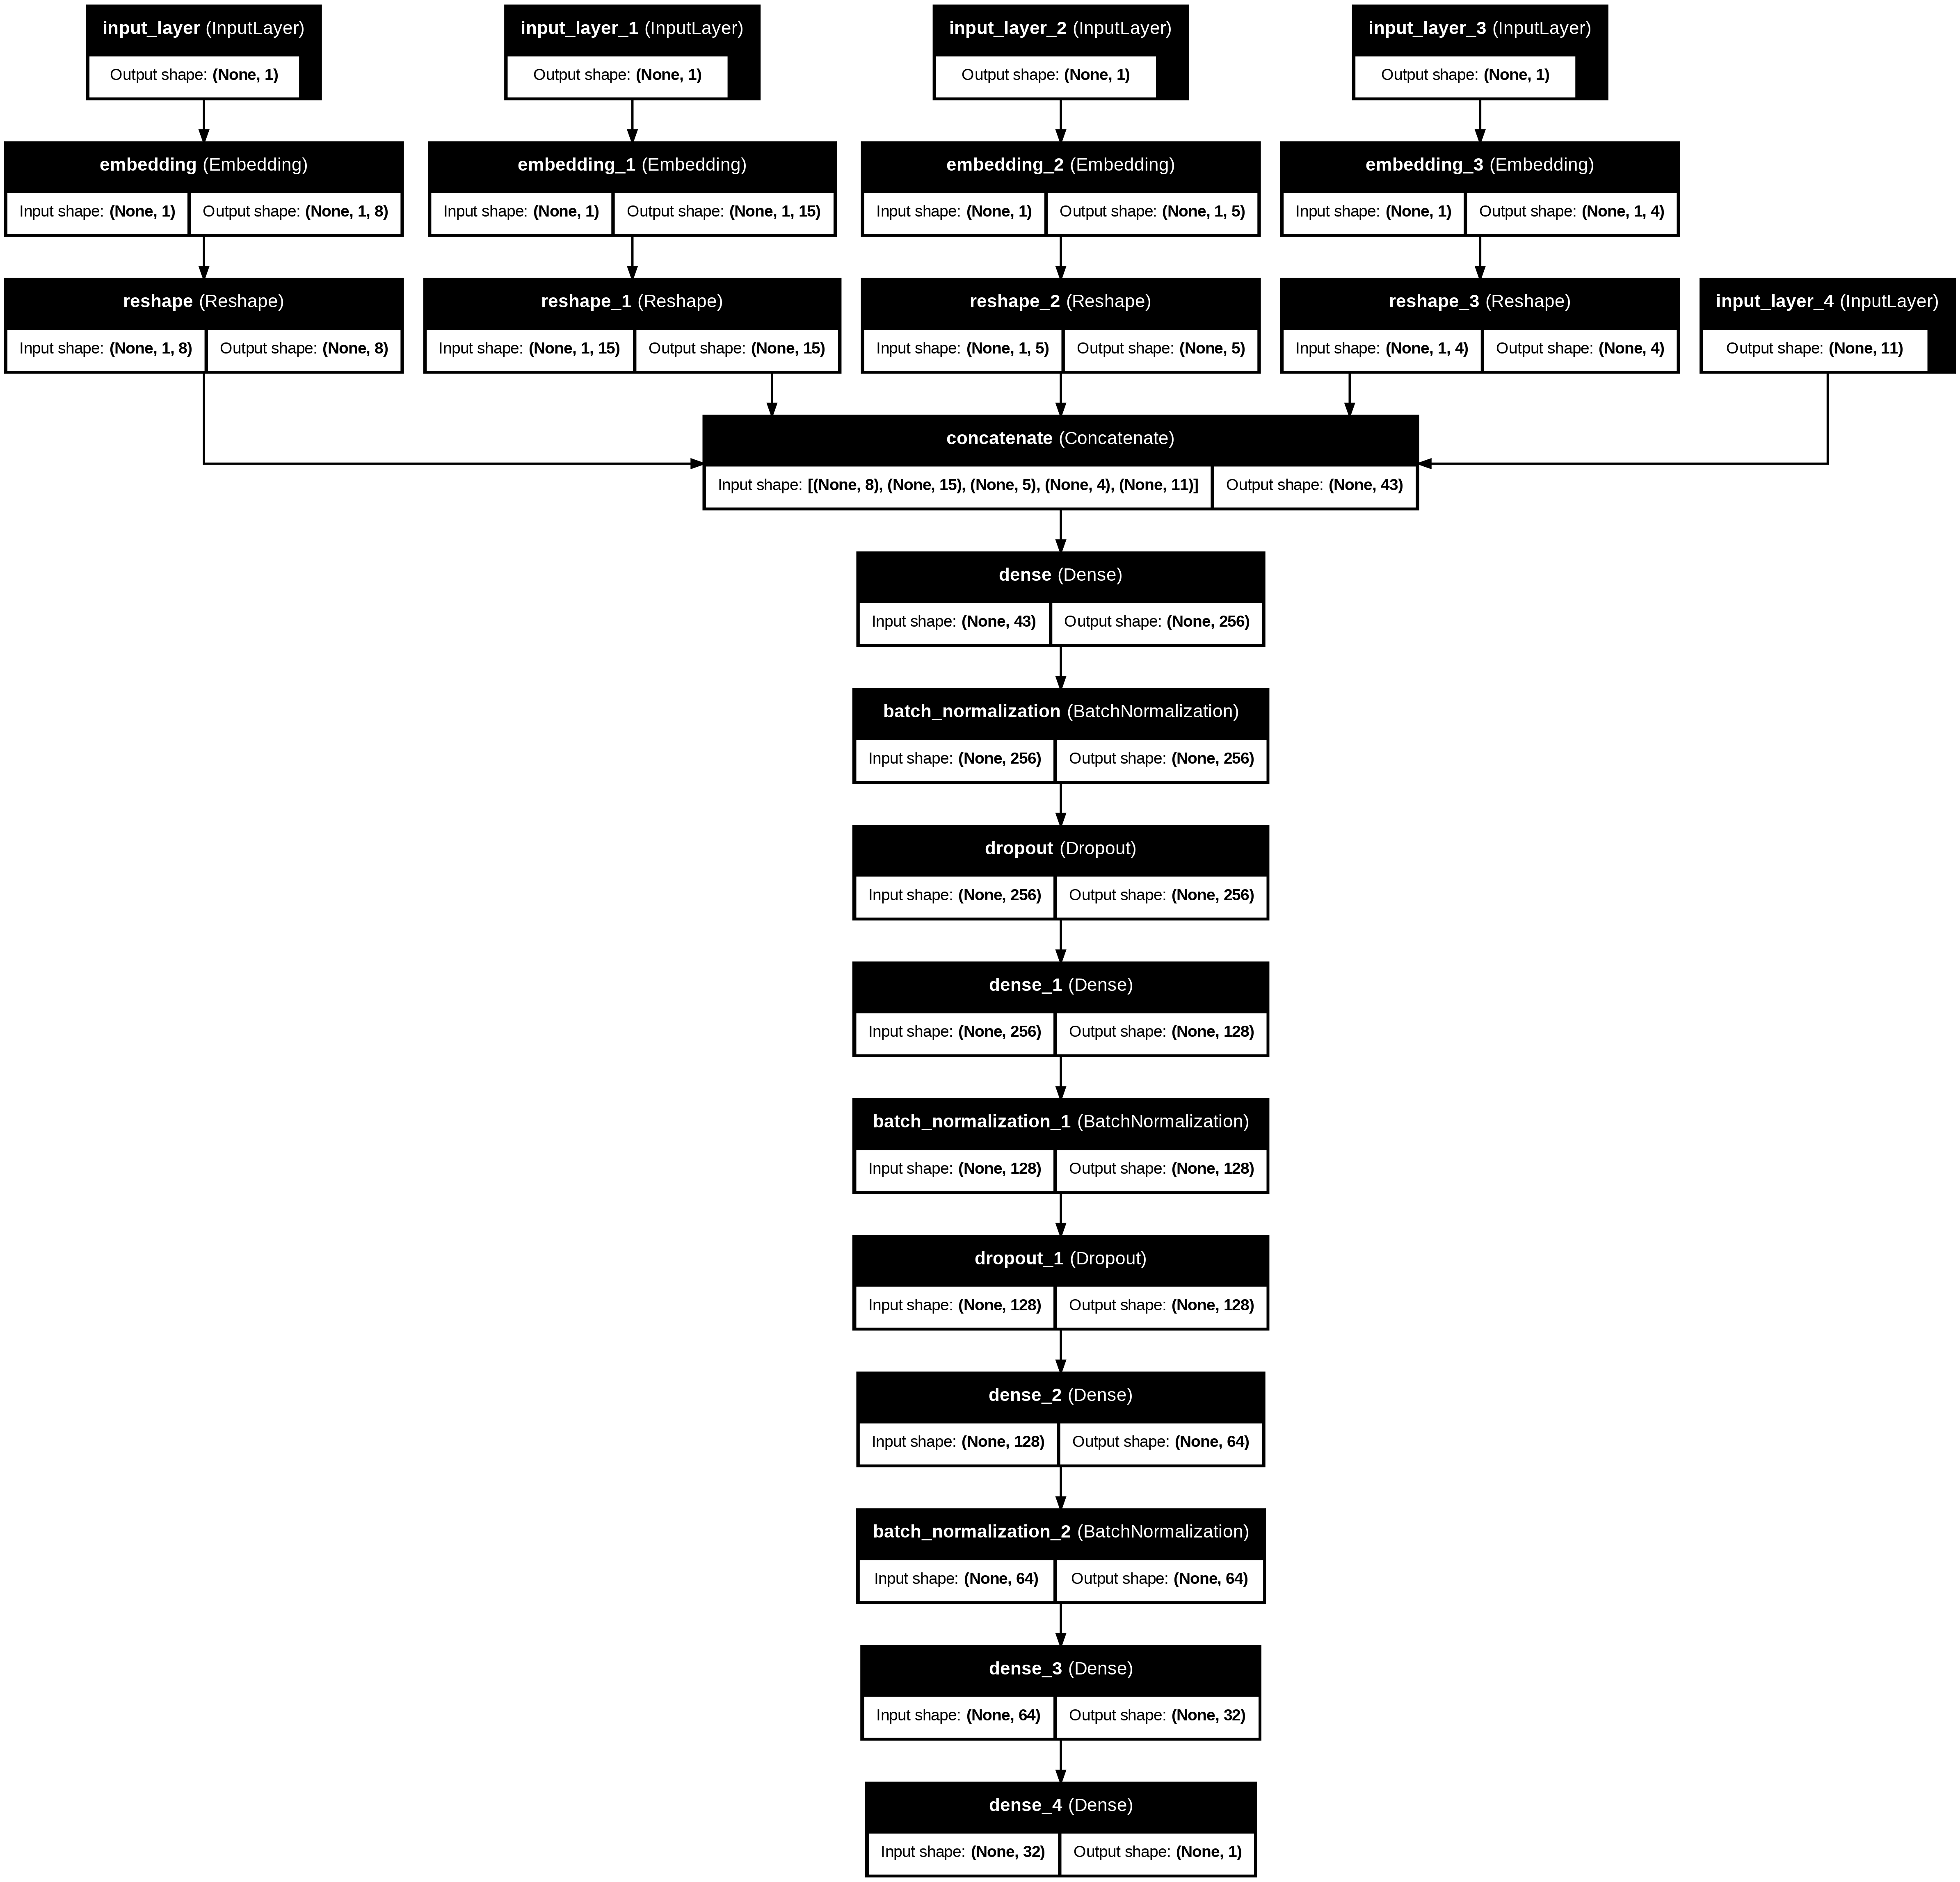

In [8]:
# Define embedding dimensions
n_unique_brand = len(np.unique(X_train_new['brand']))
n_unique_model = len(np.unique(X_train_new['model']))
n_unique_vehicleType = len(np.unique(X_train_new['vehicleType']))
n_unique_fuelType = len(np.unique(X_train_new['fuelType']))

input_brand = Input(shape=(1,))
emb_brand = Embedding(input_dim=n_unique_brand, output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,))
emb_model = Embedding(input_dim=n_unique_model, output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,))
emb_vehicleType = Embedding(input_dim=n_unique_vehicleType, output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,))
emb_fuelType = Embedding(input_dim=n_unique_fuelType, output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(numeric_cols),))
emb_numeric = input_numeric

input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, emb_numeric]

# Concatenate embeddings
model_data = Concatenate()(emb_data)

# Deeper MLP
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs = Dense(1, activation='sigmoid')(x)

nn = Model(inputs=input_data, outputs=outputs, name='Enhanced_EE_MLP')
print("\nTóm tắt mô hình MLP:")
nn.summary()
plot_model(nn, show_shapes=True, show_layer_names=True, to_file='Enhanced_EE_MLP.png')
Image(retina=True, filename='Enhanced_EE_MLP.png')

Cell 7: Train the MLP Model

Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.4052 - mae: 0.0843 - val_loss: 0.0375 - val_mae: 0.1459 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0108 - mae: 0.0540 - val_loss: 0.0161 - val_mae: 0.0734 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0094 - mae: 0.0508 - val_loss: 0.0159 - val_mae: 0.0775 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0089 - mae: 0.0505 - val_loss: 0.0127 - val_mae: 0.0702 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0091 - mae: 0.0507 - val_loss: 0.0104 - val_mae: 0.0543 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0089 - mae: 0.0506 - val_loss: 0.0118 - val_mae: 0.0716 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0088 - mae: 0.0508 - val_loss: 0.0130 - val_mae: 0.0653 - learning_ra

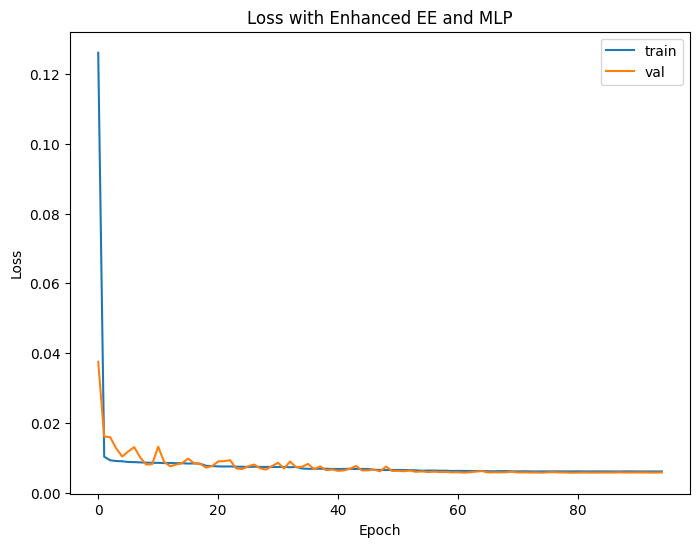

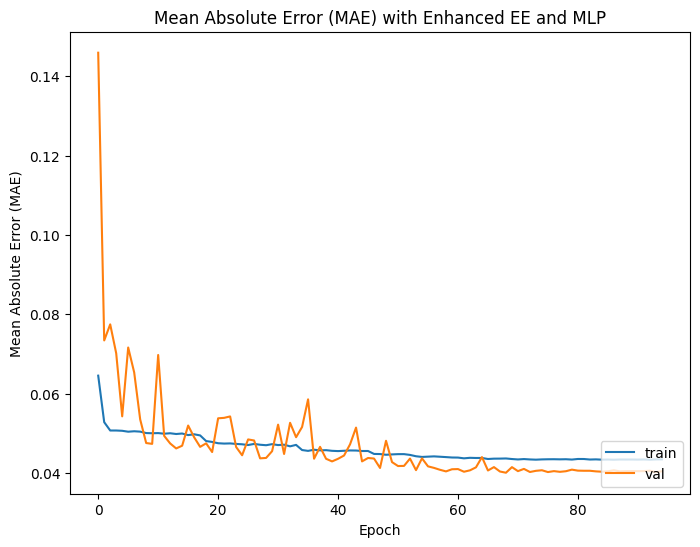

In [9]:
nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history = nn.fit(
    input_list_train_new,
    y_train_new,
    validation_data=(input_list_val, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss with Enhanced EE and MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with Enhanced EE and MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 8: Prepare Data for Random Forest

In [10]:
# For Random Forest, we need a flat feature matrix with one-hot encoded categorical variables
X_train_rf = X_train_new.copy()
X_val_rf = X_val.copy()
X_test_rf = X_test.copy()

# One-hot encode categorical variables
cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
X_train_rf = pd.get_dummies(X_train_rf, columns=cat_cols)
X_val_rf = pd.get_dummies(X_val_rf, columns=cat_cols)
X_test_rf = pd.get_dummies(X_test_rf, columns=cat_cols)

# Align columns across train, validation, and test sets
X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)
X_val_rf, X_test_rf = X_val_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

print(f"Random Forest training data shape: {X_train_rf.shape}")
print(f"Random Forest validation data shape: {X_val_rf.shape}")
print(f"Random Forest test data shape: {X_test_rf.shape}")

Random Forest training data shape: (230880, 318)
Random Forest validation data shape: (57720, 318)
Random Forest test data shape: (72150, 318)


Cell 9: Train the Random Forest Model

In [11]:
# Initialize and train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf.fit(X_train_rf, y_train_new)

# Validate on validation set
y_val_rf = rf.predict(X_val_rf)
val_mse = np.mean((y_val - y_val_rf) ** 2)
val_mae = np.mean(np.abs(y_val - y_val_rf))
print(f"Random Forest Validation MSE: {val_mse:.6f}")
print(f"Random Forest Validation MAE: {val_mae:.6f}")

Random Forest Validation MSE: 0.004295
Random Forest Validation MAE: 0.034385


Cell 10: Ensemble Predictions and Evaluation

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluation Metrics:
                Random       Naive_Mean          MLP              RF  \
MSE   316226110.937637  46713560.642554    6820195.0  5359185.510972   
RMSE      17782.747564      6834.731936  2611.550293     2314.991471   
MAE       14761.303241      4830.548835  1452.933228      1227.86805   
R2           -5.769588        -0.000017     0.853997        0.885274   
MAPE        745.297019       192.844377    44.913708       35.722972   

            Ensemble  
MSE   5545117.968112  
RMSE     2354.807416  
MAE      1292.886564  
R2          0.881293  
MAPE       39.602714  


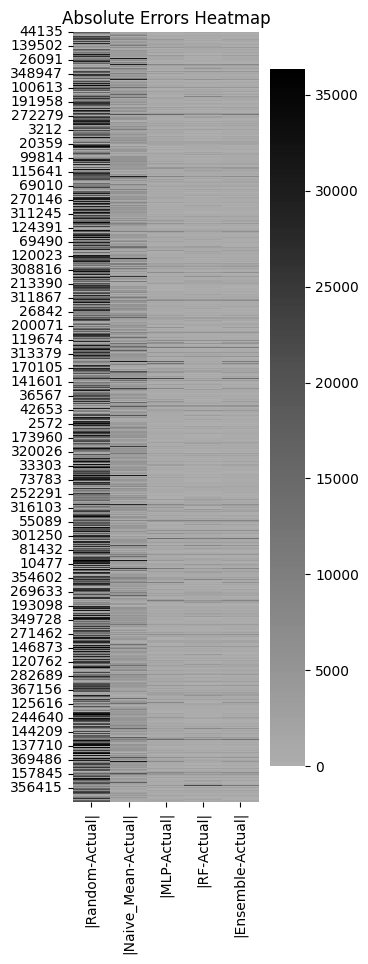

In [12]:
# MLP predictions
y_test_predict_mlp = nn.predict(input_list_test)
y_test_predict_mlp = np.clip(y_test_predict_mlp, 0, 1)
y_test_predict_mlp = price_scaler.inverse_transform(y_test_predict_mlp).flatten()

# Random Forest predictions
y_test_predict_rf = rf.predict(X_test_rf)
y_test_predict_rf = np.clip(y_test_predict_rf, 0, 1)
y_test_predict_rf = price_scaler.inverse_transform(y_test_predict_rf.reshape(-1, 1)).flatten()

# Ensemble predictions (weighted average, e.g., 0.6 MLP + 0.4 RF)
weight_mlp = 0.6
weight_rf = 0.4
y_test_predict_ensemble = (weight_mlp * y_test_predict_mlp) + (weight_rf * y_test_predict_rf)

# Inverse transform y_test
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['Random', 'Naive_Mean', 'MLP', 'RF', 'Ensemble', 'Actual'])
result_df['Actual'] = y_test_original
result_df['Naive_Mean'] = price_scaler.inverse_transform([[y_train.mean()]] * len(y_test)).flatten()
result_df['Random'] = price_scaler.inverse_transform(np.random.uniform(y_train.min(), y_train.max(), len(y_test)).reshape(-1, 1)).flatten()
result_df['MLP'] = y_test_predict_mlp
result_df['RF'] = y_test_predict_rf
result_df['Ensemble'] = y_test_predict_ensemble

# Calculate metrics
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'MAE', 'R2', 'MAPE'], columns=['Random', 'Naive_Mean', 'MLP', 'RF', 'Ensemble'])
n_test = len(result_df)

for m in metric_df.columns:
    metric_df.at['MSE', m] = np.sum((result_df['Actual'] - result_df[m])**2) / n_test
    metric_df.at['RMSE', m] = np.sqrt(metric_df.at['MSE', m])
    metric_df.at['MAE', m] = np.sum(abs(result_df['Actual'] - result_df[m])) / n_test
    ss_tot = np.sum((result_df['Actual'] - result_df['Actual'].mean())**2)
    ss_res = np.sum((result_df['Actual'] - result_df[m])**2)
    metric_df.at['R2', m] = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    non_zero_mask = result_df['Actual'] != 0
    metric_df.at['MAPE', m] = np.sum(np.abs(result_df['Actual'][non_zero_mask] - result_df[m][non_zero_mask]) / np.maximum(result_df['Actual'][non_zero_mask], 1000)) / non_zero_mask.sum() * 100

print("Evaluation Metrics:")
print(metric_df)

# Heatmap of absolute errors
for m in ['Random', 'Naive_Mean', 'MLP', 'RF', 'Ensemble']:
    result_df[f'|{m}-Actual|'] = abs(result_df[m] - result_df['Actual'])

table = result_df[['|Random-Actual|', '|Naive_Mean-Actual|', '|MLP-Actual|', '|RF-Actual|', '|Ensemble-Actual|']]
plt.figure(figsize=(3, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap')
plt.show()